# Traffic Signs Classification



A Convelutional Neural Network (CNN) used to classify real life traffic signs, gathered from the <a href='https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'>GTSRB - German Traffic Sign Recognition Benchmark</a>. The project is made using TensorFlow 2.0 and Keras

## Importing Libraries and Modules


In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
import cv2
from PIL import Image
from sklearn import metrics 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Time
import time
import datetime


## Creating Model Performance Plotting Function

We create a function to plot the model performance using matplotlib. The performance plot could also easily be made without a function, but this way is more clean and reusable.

In [2]:

def plot_performance(history = None, save_fig = None, ylim_pad = [0,0]):
    xlabel = 'Epoch'
    ylabel = 'Accuracy'
    legend = ['Training', 'Validation']

    plt.figure(figsize=(10, 5))


    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]

    plt.subplot(1, 2, 1)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(min_y, max_y)
    plt.legend(legend, loc='lower right')

    plt.grid(True)

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

    plt.subplot(1, 2, 2)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss')
    plt.xlabel(xlabel)
    plt.ylabel('Loss')
    plt.ylim(min_y, max_y)
    plt.legend(legend, loc='upper right')
    plt.grid(True)

    plt.show()
    plt.close()

## Loading and Prepping the Data

Here we loop through our training data and load the images and labels into two lists. We then convert the lists into a numpy array and reshape the images to be 30x30 pixels, so they are ready to be fed into our model. We also ***one-hot encode*** our labels to make sure there is ***no bias*** in our model, for example class 42 is more important than class 1.

In [3]:
# Loading Data
data = []
labels = []
classes = 42
cur_path = os.getcwd()
data_dir = os.path.join(cur_path, 'Data')
train_path = os.path.join(data_dir, 'train')

# Retrieving image from 'Data' folder
for index in range(classes):
    path = os.path.join(train_path, str(index))
    images = os.listdir(path)
    
    for img in images:
        try:
            image = Image.open(path + '/'+ img)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(index)
        except:
            print("Couldn't load image")

print(len(data))
print(len(labels))

data = np.array(data)
labels = np.array(labels)

# train test splitting
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# One hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

print(y_train)
    

38969
38969
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Creating the Model

Here we create the actual CNN model.

The first layer is a Conv2D layer, which applies convolutional filters to the input images to extract important features. The second and third layers are also Conv2D layers, and they further refine the features extracted by the previous layer. MaxPooling2D layers are used after the first and third Conv2D layers to reduce the spatial dimensions of the feature maps.

Dropout layers are used after each MaxPooling2D layer to prevent overfitting. Flatten layer is used to convert the output of the previous layer into a 1D array. Dense layers are then used to classify the input image based on the extracted features.

The final layer is a Dense layer with a softmax activation function, which outputs a probability distribution over the 43 possible classes. The model is then compiled by specifying the loss function, optimizer, and evaluation metric to be used during training.

In [4]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='sigmoid', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='sigmoid'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

## Training the Model

here we train our model using 25 epochs, and use our X_test and y_test from our train-test-split we made earlier as our validation data.

In [5]:
with tf.device('/device:GPU:0'):
    epochs = 25
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

# Saving our model
model.save("traffic_classifier.h5")

Epoch 1/25


2023-07-21 12:01:13.917041: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


975/975 [==============================] - 24s 20ms/step - loss: 2.5541 - accuracy: 0.2733 - val_loss: 1.3527 - val_accuracy: 0.5754
Epoch 2/25
975/975 [==============================] - 19s 19ms/step - loss: 0.8629 - accuracy: 0.7405 - val_loss: 0.4686 - val_accuracy: 0.8716
Epoch 3/25
975/975 [==============================] - 18s 19ms/step - loss: 0.4084 - accuracy: 0.8829 - val_loss: 0.2663 - val_accuracy: 0.9287
Epoch 4/25
975/975 [==============================] - 19s 19ms/step - loss: 0.2654 - accuracy: 0.9248 - val_loss: 0.2316 - val_accuracy: 0.9378
Epoch 5/25
975/975 [==============================] - 18s 19ms/step - loss: 0.1848 - accuracy: 0.9481 - val_loss: 0.1372 - val_accuracy: 0.9607
Epoch 6/25
975/975 [==============================] - 18s 19ms/step - loss: 0.1697 - accuracy: 0.9492 - val_loss: 0.1144 - val_accuracy: 0.9657
Epoch 7/25
975/975 [==============================] - 19s 19ms/step - loss: 0.1342 - accuracy: 0.9603 - val_loss: 0.1037 - val_accuracy: 0.9724
Epo

## Plotting model performance

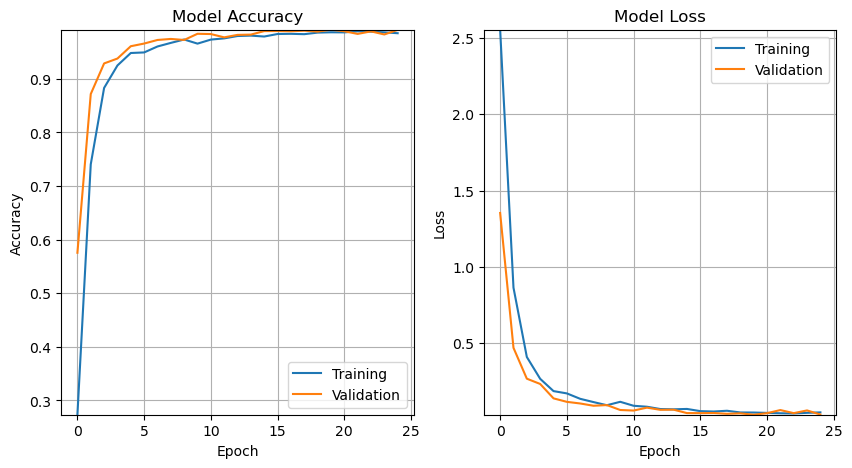

In [6]:
plot_performance(history)

## Evaluating the Model

Here we use our `Test.csv` file provided by the benchmark to evaluate our model. Like earlier we split it into two lists `labels` and `imgs`, we then iterate through the images, resizes them and converts them to a numpy array. And saves the data as `X_test`

In [7]:
y_test_data = pd.read_csv(os.path.join(data_dir, 'Test.csv'))

labels = y_test_data['ClassId'].values
imgs = y_test_data['Path'].values
data = []

for img in imgs:
    path_to_img = os.path.join(data_dir, img)
    image = Image.open(path_to_img)
    # reshape image to 30x30
    image = image.resize([30,30])
    data.append(np.array(image))

X_test = np.array(data) 
# print(X_test)

Here we use our saves np.array `X_test` to predict the labels of the images, and compares it to the actual labels gathered from `Test.csv`. And then we pass it to the ***classification_report*** function from sklearn.metrics to get a detailed report of our models performance including our ***accuracy***, ***recall***, ***f1-score*** and ***support***.

In [8]:
with tf.device('/device:GPU:0'):
    predictions = np.argmax(model.predict(X_test), axis=-1)

from sklearn.metrics import accuracy_score
print(accuracy_score(labels, predictions))

print(classification_report(labels, predictions))

395/395 [==============================] - 1s 3ms/step
0.9563737133808393
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.97      0.99      0.98       720
           2       0.98      0.99      0.99       750
           3       0.96      0.96      0.96       450
           4       0.99      0.98      0.98       660
           5       0.94      0.96      0.95       630
           6       0.94      0.83      0.88       150
           7       0.94      0.98      0.96       450
           8       0.96      0.96      0.96       450
           9       0.94      1.00      0.97       480
          10       0.96      0.99      0.98       660
          11       0.92      0.99      0.95       420
          12       0.99      0.98      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.96      0.92      0.94       210
       

/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Testing the Model on Real Images

Here we load our model from our `traffic_classifier.h5` file. And then create a function to preprocess our input image, so it can be fed to our model. And then we use `.predict()` to predict the class of our input image. 

After we get our class we call our `get_class_image` function to search the `Meta` with an image of the class number. And then we plot the input image vs the predicted class image against each other

1/1 [==============================] - 1s 931ms/step
The predicted class is 23


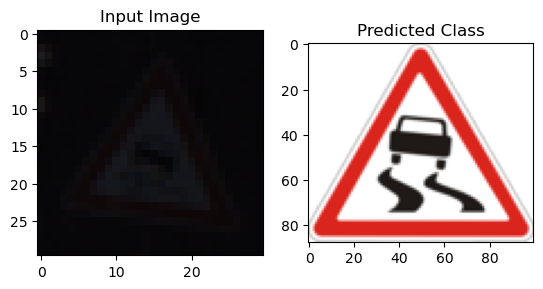

In [9]:
from keras.models import load_model

classificer = load_model('traffic_classifier.h5')

def preprocess_input_img(img):
    image = Image.open(img)
    image = image.resize((30,30))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    return image

def get_class_image(class_no):
    Meta_dir = os.path.join(data_dir, 'Meta')
    img = os.path.join(Meta_dir, str(class_no) + '.png')
    img = Image.open(img)
    return img

input_img = preprocess_input_img('Data/test/00012.png')
prediction = int(np.argmax(classificer.predict(input_img), axis=-1))
print(f'The predicted class is {prediction}')
class_img = get_class_image(prediction)

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_img[0])

plt.subplot(1, 2, 2)
plt.title('Predicted Class')
plt.imshow(class_img)


